In [46]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, Iterable, List, Sequence

import pandas as pd
import matplotlib.pyplot as plt

In [47]:
SUM_FIELDS = {
    "Energy [J]",
    "Power [W]",
    "Energy PP0 [J]",
    "Power PP0 [W]",
    "Energy DRAM [J]",
    "Power DRAM [W]",
    "Energy PLATFORM [J]",
    "Power PLATFORM [W]",
    "Memory read bandwidth [MBytes/s]",
    "Memory read data volume [GBytes]",
    "Memory write bandwidth [MBytes/s]",
    "Memory write data volume [GBytes]",
    "Memory bandwidth [MBytes/s]",
    "Memory data volume [GBytes]",
    "L3 request rate",
    "L3 miss rate",
    "L3 miss ratio",
    "Energy Core [J]",
    "Power Core [W]",
    "Energy L3 [J]",
    "Power L3 [W]",
}



def find_apps_dir(start: Path) -> Path:
    current = start.resolve()
    for _ in range(6):
        candidate = current / 'apps'
        if candidate.is_dir():
            return candidate
        if current.parent == current:
            break
        current = current.parent
    raise FileNotFoundError('No apps directory found. Run from repo root or set apps_dir manually.')


def _list_candidates(folder: Path, job: str, *, include_timeline: bool) -> List[Path]:
    pattern = f"*.{job}.out"
    candidates = sorted(folder.glob(pattern))
    if include_timeline:
        return [p for p in candidates if "timeline" in p.name]
    return [p for p in candidates if "timeline" not in p.name and not p.name.startswith("likwid_")]


def find_job_file(folder: Path, job: str, *, include_timeline: bool) -> Path:
    matches = _list_candidates(folder, job, include_timeline=include_timeline)
    if not matches:
        raise FileNotFoundError(f"No {'timeline' if include_timeline else 'stdout'} file found for job {job} in {folder}")
    if len(matches) > 1:
        print(f"Multiple candidates found; using {matches[0].name}. Override via stdout_file/timeline_file if needed.")
    return matches[0]


def extract_job_id_from_name(path: Path | str) -> str:
    name = path.name if isinstance(path, Path) else Path(path).name
    parts = name.split(".")
    if len(parts) < 3:
        raise ValueError(f"Could not infer job id from {name}")
    return parts[-2]


def find_group_timeline(folder: Path, prefix: str) -> Path:
    pattern = f"{prefix}.*.out"
    candidates = sorted(folder.glob(pattern))
    if not candidates:
        raise FileNotFoundError(f"No timeline files matching '{prefix}' found in {folder}")
    return max(candidates, key=lambda p: (p.stat().st_mtime, p.name))


def build_jobs_config(
    out_dir: Path,
    timeline_dir: Path,
    patterns: dict[str, str],
    overrides: dict[str, dict[str, str | Path | None]],
) -> dict[str, dict[str, str | Path | None]]:
    jobs: dict[str, dict[str, str | Path | None]] = {}
    overrides = overrides or {}
    for label, prefix in patterns.items():
        if label in overrides:
            jobs[label] = overrides[label]
            continue
        timeline_path = find_group_timeline(timeline_dir, prefix)
        job_id = extract_job_id_from_name(timeline_path)
        stdout_path = find_job_file(out_dir, job_id, include_timeline=False)
        jobs[label] = {
            "job_id": job_id,
            "stdout_file": stdout_path,
            "timeline_file": timeline_path,
        }
    for label, cfg in overrides.items():
        jobs[label] = cfg
    return jobs


def parse_headers(stdout_path: Path) -> List[Sequence[str]]:
    headers: List[Sequence[str]] = []
    with stdout_path.open() as handle:
        for line in handle:
            if line.startswith("# GID|"):
                parts = line.lstrip("#").strip().split("|")
                fields = parts[3:]
                if fields:
                    headers.append(fields)
    if not headers:
        raise RuntimeError(f"No LIKWID headers found in {stdout_path}")
    return headers


def aggregate_metric(values: Sequence[float], field: str) -> float:
    if not values:
        raise KeyError(f"Missing values for field {field}")
    if field in SUM_FIELDS:
        return float(sum(values))
    return float(sum(values) / len(values))


def load_likwid_timeseries(stdout_path: Path, timeline_path: Path) -> pd.DataFrame:
    headers_queue = parse_headers(stdout_path)
    gid_headers: Dict[int, Sequence[str]] = {}
    rows: List[Dict[str, float]] = []
    current: Dict[str, float] | None = None

    with timeline_path.open() as handle:
        for raw_line in handle:
            line = raw_line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split(",")
            gid = int(parts[0])
            metrics_count = int(parts[1])
            cpu_count = int(parts[2])
            values = [float(val) for val in parts[3:]]

            header = gid_headers.get(gid)
            if header is None:
                if not headers_queue:
                    raise RuntimeError(f"Missing header description for GID {gid}")
                header = headers_queue.pop(0)
                gid_headers[gid] = header

            global_field = header[0]
            metric_fields = header[1:]
            if len(metric_fields) != metrics_count:
                raise ValueError(
                    f"GID {gid}: header mismatch (expected {metrics_count} metrics, got {len(metric_fields)})"
                )

            expected_values = 1 + metrics_count * cpu_count
            if len(values) != expected_values:
                raise ValueError(
                    f"GID {gid}: expected {expected_values} numeric entries, got {len(values)}"
                )

            global_value = values[0]
            metric_values = values[1:]

            extracted: Dict[str, float] = {global_field: global_value}
            for idx, field in enumerate(metric_fields):
                start = idx * cpu_count
                end = start + cpu_count
                segment = metric_values[start:end]
                if not segment:
                    continue
                extracted[field] = aggregate_metric(segment, field)

            if gid == 1 or not rows:
                current = {"sample_index": len(rows)}
                rows.append(current)
            elif current is None:
                current = rows[-1]

            current.update(extracted)

    if not rows:
        raise RuntimeError("No LIKWID samples parsed from timeline file")

    df = pd.DataFrame(rows).set_index("sample_index").sort_index()
    return df

def load_energy_profile(app: str, freq: str, *, apps_dir: Path | None = None, group: str = 'energy') -> pd.DataFrame:
    if apps_dir is None:
        apps_dir = find_apps_dir(Path.cwd())

    out_path = apps_dir / app / f"{app}_{group}_{freq}.out"
    prof_path = apps_dir / app / f"{app}_{group}_{freq}.prof"
    if not out_path.exists():
        raise FileNotFoundError(f"Missing header file: {out_path}")
    if not prof_path.exists():
        raise FileNotFoundError(f"Missing profile file: {prof_path}")

    headers = parse_headers(out_path)
    if len(headers) != 1:
        print(f'Warning: expected 1 header set, found {len(headers)} in {out_path.name}')
    header = headers[0]
    global_field = header[0]
    metric_fields = header[1:]

    rows: List[Dict[str, float]] = []
    in_loop = False
    saw_start = False
    saw_end = False

    with prof_path.open() as handle:
        for raw_line in handle:
            line = raw_line.strip()
            if not line:
                continue
            if line.startswith('LOOP_START_REL'):
                in_loop = True
                saw_start = True
                continue
            if line.startswith('LOOP_END_REL'):
                in_loop = False
                saw_end = True
                break
            if not in_loop:
                continue
            if line.startswith('#'):
                continue
            parts = line.split(',')
            if len(parts) < 4:
                continue
            gid = int(parts[0])
            metrics_count = int(parts[1])
            cpu_count = int(parts[2])
            values = [float(val) for val in parts[3:]]

            if metrics_count != len(metric_fields):
                raise ValueError(
                    f'Header mismatch: expected {len(metric_fields)} metrics, got {metrics_count} in {prof_path.name}'
                )

            expected_values = 1 + metrics_count * cpu_count
            if len(values) != expected_values:
                raise ValueError(
                    f'Expected {expected_values} numeric entries, got {len(values)} in {prof_path.name}'
                )

            global_value = values[0]
            metric_values = values[1:]

            extracted: Dict[str, float] = {global_field: global_value}
            for idx, field in enumerate(metric_fields):
                start = idx * cpu_count
                end = start + cpu_count
                segment = metric_values[start:end]
                if not segment:
                    continue
                extracted[field] = aggregate_metric(segment, field)

            extracted['gid'] = gid
            rows.append(extracted)

    if not saw_start:
        raise RuntimeError(f'LOOP_START_REL marker not found in {prof_path.name}')
    if not saw_end:
        raise RuntimeError(f'LOOP_END_REL marker not found in {prof_path.name}')
    if not rows:
        raise RuntimeError(f'No samples found between loop markers in {prof_path.name}')

    return pd.DataFrame(rows)

def clean_abnormal(df: pd.DataFrame, *, z_thresh: float = 8.0, cols: list[str] | None = None) -> pd.DataFrame:
    numeric_cols = [c for c in df.columns if c != "gid"]
    if cols is None:
        cols = numeric_cols
    cleaned = df.copy()
    for col in cols:
        if col not in cleaned.columns:
            continue
        series = cleaned[col]
        median = series.median()
        mad = (series - median).abs().median()
        if mad == 0 or series.isna().all():
            continue
        robust_z = (series - median).abs() / (1.4826 * mad)
        mask = robust_z > z_thresh
        if mask.any():
            cleaned.loc[mask, col] = pd.NA
            cleaned[col] = cleaned[col].ffill().bfill()
    return cleaned

def plot_metric(df: pd.DataFrame, metric_to_plot: str) -> None:
    if metric_to_plot not in df.columns:
        raise ValueError(f"Metric '{metric_to_plot}' not found. Choose one of: {sorted(df.columns)}")

    time_axis = df["Total runtime [s]"] if "Total runtime [s]" in df.columns else df.index
    time_label = "Total runtime [s]" if "Total runtime [s]" in df.columns else "Sample index"

    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, df[metric_to_plot], marker="")
    plt.xlabel(time_label)
    plt.ylabel(metric_to_plot)
    plt.title(f"{metric_to_plot} across LIKWID samples")
    plt.grid(True)
    plt.tight_layout()


In [48]:
# ['CPI', 'Clock [MHz]', 'Energy Core [J]', 'Energy L3 [J]', 'Power Core [W]', 'Power L3 [W]', 'Runtime (RDTSC) [s]', 'Runtime unhalted [s]', 'Total runtime [s]', 'gid']

df = load_energy_profile("io_write", "2.25GHz")
df = clean_abnormal(df)


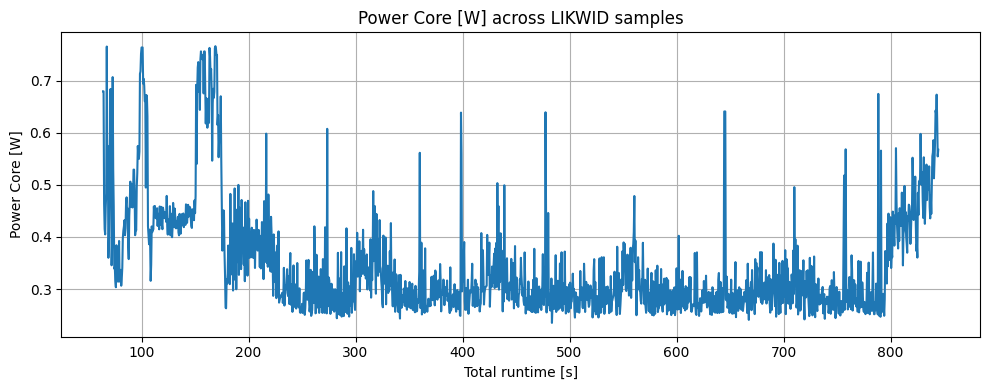

In [49]:
metric_to_plot = "Power Core [W]"
plot_metric(df, metric_to_plot)

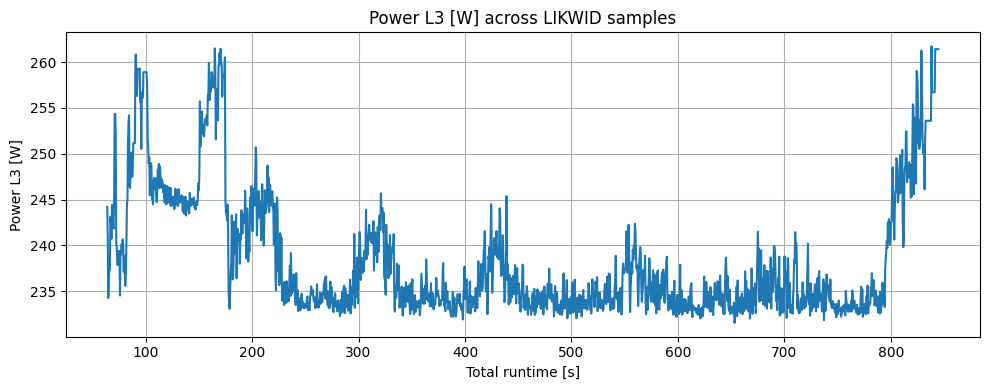

In [50]:
metric_to_plot = "Power L3 [W]"
plot_metric(df, metric_to_plot)